# pip installs

In [ ]:
!pip install llvmpy
!pip install cython #==0.29.24
!pip install numba #==0.56.2
!pip install pandas #==1.3.4
!pip install networkx #==2.6.3
!pip install matplotlib #==3.4.3
!pip install ts2vg #==1.0.0
!pip install pytorch_lightning==1.6.5
!pip install tensorflow #==2.11.0
!pip install dvclive #==1.3.3
!pip install torchsummary #==1.5.1
!pip install torchmetrics==0.6.0

# pip from 31/1 forward

In [1]:
!mamba install pytorch-cuda=11.6 -c pytorch -c conda-forge -c nvidia -y -q

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [2]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116 -q

In [3]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.1+cu116.html -q

In [4]:
!pip install ts2vg -q

In [5]:
!pip install pytorch_lightning==1.9.1 -q

In [6]:
!mamba install tensorflow-gpu -y -q

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... By downloading and using the CUDA Toolkit conda packages, you accept the terms and conditions of the CUDA End User License Agreement (EULA): https://docs.nvidia.com/cuda/eula/index.html

By downloading and using the cuDNN conda packages, you accept the terms and conditions of the NVIDIA cuDNN EULA -
  https://docs.nvidia.com/deeplearning/cudnn/sla/index.html

done


In [7]:
!mamba install -c conda-forge pyts -q -y #==0.12.0

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [8]:
!pip install torchsummary -q

In [9]:
!pip install dvclive==2.0.2 -q

# Main code

In [1]:
"""
bellow are listed all nedded libraries
"""

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import warnings
import sklearn
import os.path as osp
import matplotlib.pyplot as plt
import ts2vg
import pytorch_lightning as pl
import tensorflow as tf
import datetime

from pyts.image import MarkovTransitionField

from torch.nn import Linear, CrossEntropyLoss, BCEWithLogitsLoss
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool, ChebConv, global_sort_pool
from torch_geometric.loader import DataLoader
from torch.nn import Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv, GINEConv, GATv2Conv, GATConv

from tqdm import tqdm

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE

from torchvision import transforms

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import ProgressBarBase
from pytorch_lightning.loggers import TensorBoardLogger
#from pytorch_lightning.loggers import CSVLogger
from dvclive.lightning import DVCLiveLogger

#from torchsummary import summary

from ts2vg import NaturalVG
from ts2vg import HorizontalVG

2023-02-21 07:04:59.653008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Main code

In [2]:
def devisor(x, window_size):
    divisors = []
    for i in range(1, x+1):
        if x % i == 0:  # if i divides x with 0 remainder
            divisors.append(i)  # add i to the list of divisors
    
    # print(divisors)  # print the list of divisors
    for i in range(len(divisors)):
        if divisors[i] >= int(window_size/4):
            return divisors[i]
        
def create_Y(mask):
    Y = []
    for i in mask:
        if 1 in i:
            Y.append(1)
        else:
            Y.append(0)
    return Y
        
def create_windows(data, mask=[], window_size=300, mask_is = 1, stride_on = True):
    if stride_on == True:
        stride = devisor(int(len(data) - window_size),window_size)
        # print(stride)
        num_windows = (len(data) - window_size) // stride + 1
        windows = np.zeros((num_windows, window_size))

        for i in range(num_windows):
            windows[i, :] = data[i * stride:i * stride + window_size]

        if mask_is == 0:
            return windows
        else:
            mask = create_windows(data = mask, window_size = window_size, mask_is = 0)
            Y = create_Y(mask)
            return windows, mask, Y
    elif stride_on == False:
        windows = data.to_numpy().reshape(-1, 203)
        if mask_is == 0:
            return windows
        else:
            mask = mask.to_numpy().reshape(-1, 203)
            Y = create_Y(mask)
            return windows, mask, Y


In [3]:
"""

in this bracket of code is located the conversion of time series to different graph neural networks (Markov transition field (MTF) and Visibility graphs (VG)) 
with different lengths (uncut(300), cut and random(where every sample has a different length between 300 and 50)).

create graph is called when we have a time series that needs to be converted into a graph. I

"""
def vis_matrix(X_current, vis_type_local):
    if vis_type_local == "natural":
        g = NaturalVG(weighted=vis_distance)
    elif vis_type_local == "horizontal":
        g = HorizontalVG(weighted=vis_distance)

    g.build(X_current)

    adj_mat_vis = np.zeros([len(X_current),len(X_current)], dtype='float')
    for i in range(len(g.edges)):
        x, y, q =g.edges[i]
        adj_mat_vis[x,y] = q
        if vis_edge_type == "undirected":
            adj_mat_vis[y,x] = q

    return adj_mat_vis

    # functions for creating edge index and edge weight for a given matrix
def adjToEdgidx(adj_mat):
    #function for visibility and MTF matrixes
    edge_index = torch.from_numpy(adj_mat).nonzero().t().contiguous()
    row, col = edge_index
    edge_weight = adj_mat[row, col]
    return edge_index,edge_weight

def adjToEdgidx_dual_VG(X_current):
    #function for joined visibility and MTF matrixes
    pos_adj_mat_vis = vis_matrix(X_current, vis_type)
    neg_adj_mat_vis = vis_matrix(-X_current, vis_type)

    edge_index = torch.from_numpy(pos_adj_mat_vis+neg_adj_mat_vis).nonzero().t().contiguous()

    #join two edge_weight arrays
    row, col = edge_index
    edge_weight = np.zeros([len(row),2], dtype='float')
    edge_weight[:,0] = pos_adj_mat_vis[row, col]
    edge_weight[:,1] = neg_adj_mat_vis[row, col]
    return edge_index, edge_weight

def define_mask(i):
    if classif == "graph": # for graph classification
        return torch.tensor(Y[i], dtype=torch.long)
    elif classif == "node":# for node classification 
        return torch.unsqueeze(torch.tensor(X_mask[i], dtype=torch.double),1)

def create_graph():
    
    output = []
    import os, sys
    versions = os.listdir('datasets/Yahoo/'+version)
    versions = list(filter(lambda x: ".ipynb_checkpoints" not in x, versions))
    
    len_ver = len(versions)

    for loc_ver in versions: #range(1,len_ver+1)
        df = pd.read_csv("datasets/Yahoo/"+version+"/" + loc_ver)  
    
        global X, X_mask, Y, class_weights
        if version in ("A1Benchmark", "A2Benchmark"):
            X, X_mask, Y = create_windows(df.value,df.is_anomaly,window_size,stride_on = stride_on)
        elif version in ("A3Benchmark", "A4Benchmark"):
            X, X_mask, Y = create_windows(df.value,df.anomaly,window_size,stride_on = stride_on)
            
        if graph_type in ("MTF", "vis_on_MTF", "MTF_on_vis"):
            MTF = MarkovTransitionField(n_bins=int(window_size/2))
            X_gaf_MTF = MTF.fit_transform(X)

        # output will contain all graphs 

        # setting class_weights for graph 

        
        for i in range(len(X)):
            if graph_type == "MTF": 
                edge_index, edge_weight = adjToEdgidx(X_gaf_MTF[i])
            elif graph_type == "vis":
                edge_index, edge_weight = adjToEdgidx(vis_matrix(X[i],vis_type))
            elif graph_type == "dual_VG":
                edge_index, edge_weight = adjToEdgidx_dual_VG(X[i])
                
            x =  torch.unsqueeze(torch.tensor(X[i], dtype=torch.double), 1).clone().detach()
            edge_index = edge_index.clone().detach().to(torch.int64)
            edge_attr = torch.unsqueeze(torch.tensor(edge_weight, dtype=torch.double),1).clone().detach()
            y = define_mask(i)

            output.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y))    
    
    global class_weights
    all_x = []
    for obj in output:
        all_x.append(obj.y.numpy())
    all_x = np.array(all_x).reshape(-1)
    
    
    class_weights = torch.tensor(class_weight.compute_class_weight(class_weight='balanced',
                                                                    classes=np.unique(all_x),
                                                                    y=all_x))
    if classif == "node":
        class_weights =torch.tensor([class_weights[1]/class_weights[0]])
    
    return output    

In [4]:
"""
in this function we use GINE for graph classification and Net for node classidication using Pytorch Lightning for the graphs we created by using the create_graph function.
This function also incorporates callbacks for easier and faster result agregation.
"""

# class for node classification            
class GINE(pl.LightningModule):
    def __init__(self):
        super(GINE, self).__init__()
        
        if graph_type in ("MTF", "vis"):
            edge_dim = 1
        elif graph_type in ("MTF_on_vis", "vis_on_MTF", "double_VG", "dual_VG"):
            edge_dim = 2
            
        dim_h = 32
    
        self.conv1 = GINEConv(
            Sequential(Linear(dim_h, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.conv2 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.conv3 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.conv4 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.conv5 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        
        self.lin1 = Linear(dim_h*5, dim_h*5)
        self.lin2 = Linear(dim_h*5, 2)
    
    
    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Node embeddings 
        h1 = self.conv1(x, edge_index, edge_attr=edge_weight)
        h2 = self.conv2(h1, edge_index, edge_attr=edge_weight)
        h3 = self.conv3(h2, edge_index, edge_attr=edge_weight)
        h4 = self.conv4(h3, edge_index, edge_attr=edge_weight)
        h5 = self.conv5(h4, edge_index, edge_attr=edge_weight)
        
        # Graph-level readout
        
        h1 = global_max_pool(h1, batch)
        h2 = global_max_pool(h2, batch)
        h3 = global_max_pool(h3, batch)
        h4 = global_max_pool(h4, batch)
        h5 = global_max_pool(h5, batch)
        
        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3, h4, h5), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return h
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
                     
        out = model(train_batch)
        loss_function = CrossEntropyLoss(weight=class_weights).to(device)
        train_loss = loss_function(out, train_batch.y)
        
        correct=out.argmax(dim=1).eq(train_batch.y).sum().item()
        logs={"train_loss": train_loss}
        total=len(train_batch.y)
        
        batch_dictionary={"loss": train_loss, "log": logs, "correct": correct, "total": total}
        return train_loss
    
    
    def validation_step(self, val_batch, batch_idx):
      
        out = model(val_batch)
        loss_function = CrossEntropyLoss(weight=class_weights).to(device)
        val_loss = loss_function(out, val_batch.y)
        
        pred = out.argmax(-1)
        correct=out.argmax(dim=1).eq(val_batch.y).sum().item()
        total=len(val_batch.y)
        val_label = val_batch.y
        accuracy = (pred == val_label).sum() / pred.shape[0]
        
        logs={"train_loss": val_loss}
        batch_dictionary={"loss": val_loss, "log": logs, "correct": correct, "total": total}
        
        self.log("val_loss", val_loss)
        self.log("val_acc", accuracy)
        
    
    def test_step(self, test_batch, batch_idx):
        out = model(test_batch)
        loss_function = CrossEntropyLoss(weight=class_weights).to(device)
        test_loss = loss_function(out, test_batch.y)
        
        pred = out.argmax(-1)
        test_label = test_batch.y
        accuracy = (pred == test_label).sum() / pred.shape[0]
        self.log("test_true", test_label)
        self.log("test_pred", pred)
        self.log("test_acc", accuracy)
        return pred, test_label
        
    def test_epoch_end(self, outputs):
        #this function gives us in the outputs all acumulated pred and test_labels we returned in test_step
        #we transform the pred and test_label into a shape that the classification report can read
        true_array=[]
        pred_array = []
        for i in range(len(outputs)):
            true_array = np.append(true_array,outputs[i][1].cpu().numpy())
            pred_array = np.append(pred_array,outputs[i][0].cpu().numpy())     
        print(confusion_matrix(true_array, pred_array))
        print(classification_report(true_array, pred_array))
        return pred_array, true_array
    
#---------------------------------------------------------------------------------
# class for node classification
class Net(pl.LightningModule):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = GATConv(1, 32, heads=4)
        self.lin1 = torch.nn.Linear(1, 4 * 32)
        self.conv2 = GATConv(4 * 32, 32, heads=4)
        self.lin2 = torch.nn.Linear(4 * 32, 4 * 32)
        self.conv3 = GATConv(4 * 32, 32, heads=8)
        self.lin3 = torch.nn.Linear(4 * 32, 8 * 32)
        self.conv4 = GATConv(8 * 32, 1, heads=6,concat=False)
        self.lin4 = torch.nn.Linear(8 * 32, 1)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        
        x = F.elu(self.conv1(x, edge_index, edge_weight) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index, edge_weight) + self.lin2(x))
        x = F.elu(self.conv3(x, edge_index, edge_weight) + self.lin3(x))
        x = self.conv4(x, edge_index, edge_weight) + self.lin4(x)
        return x

#         self.conv1 = GATConv(1, 32, heads=4)
#         self.lin1 = torch.nn.Linear(1, 4 * 32)
#         self.conv2 = GATConv(4 * 32, 32, heads=4)
#         self.lin2 = torch.nn.Linear(4 * 32, 4 * 32)
#         self.conv3 = GATConv(4 * 32, 1, heads=6,concat=False)
#         self.lin3 = torch.nn.Linear(4 * 32, 1)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
        
#         x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
#         x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
#         x = self.conv3(x, edge_index) + self.lin3(x)
#         return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
        return optimizer
    


    def training_step(self, train_batch, batch_idx):        
        out = model(train_batch)
        loss_function = BCEWithLogitsLoss(weight=class_weights).to(device) #weight=class_weight
        
        
        train_loss = loss_function(out, train_batch.y)
        correct=out.argmax(dim=1).eq(train_batch.y).sum().item()
        logs={"train_loss": train_loss}
        total=len(train_batch.y)
        
        batch_dictionary={"loss": train_loss, "log": logs, "correct": correct, "total": total}
        
        return train_loss
    
    
    def validation_step(self, val_batch, batch_idx):
      
        out = model(val_batch)
        loss_function = BCEWithLogitsLoss(weight=class_weights).to(device) #weight=class_weight
        val_loss = loss_function(out, val_batch.y)
        
        ys, preds = [], []
        val_label = val_batch.y.cpu()
        ys.append(val_batch.y)
        preds.append((out > 0).float().cpu())     
        y, pred = torch.cat(ys, dim=0), torch.cat(preds, dim=0)
        accuracy = (pred == val_label).sum() / pred.shape[0]
    
        self.log("val_loss", val_loss)
        self.log("val_acc", accuracy)
    
    def test_step(self, test_batch, batch_idx):
        # this is the test loop
        out = model(test_batch)
        loss_function = BCEWithLogitsLoss(weight=class_weights).to(device) #weight=class_weight
        test_loss = loss_function(out, test_batch.y)
        
        ys, preds = [], []
        test_label = test_batch.y.cpu()
        ys.append(test_batch.y)
        preds.append((out > 0).float().cpu())
        
        y, pred = torch.cat(ys, dim=0), torch.cat(preds, dim=0)
        accuracy = (pred == test_label).sum() / pred.shape[0]
        
        self.log("test_acc", accuracy)
        return pred, y
        
    def test_epoch_end(self, outputs):
        #this function gives us in the outputs all acumulated pred and test_labels we returned in test_step
        #we transform the pred and test_label into a shape that the classification report can read
        global true_array, pred_array
        true_array=[outputs[i][1].cpu().numpy() for i in range(len(outputs))]
        pred_array = [outputs[i][0].cpu().numpy() for i in range(len(outputs))]
        pred_array = np.array(pred_array).reshape(-1, 1)
        true_array = np.array(true_array).reshape(-1, 1)
        print(confusion_matrix(true_array, pred_array))
        print(classification_report(true_array, pred_array))
        print("pred_array ",pred_array)

        
def main():
    if check_for_missclick() != True:
        print("one of the main parameters does not match")
    else:
        global model, test_loader, device
        
        early_stop = EarlyStopping(monitor='val_acc',patience=patience, strict=False,verbose=False, mode='max')
        # val_checkpoint_acc = ModelCheckpoint(filename="max_acc-{epoch}-{step}-{val_acc:.3f}", monitor = "val_acc", mode="max")
        # val_checkpoint_best_loss = ModelCheckpoint(filename="best_loss", monitor = "val_loss", mode="max")
        val_checkpoint_best_acc = ModelCheckpoint(filename="best_acc", monitor = "val_acc", mode="max")
        # val_checkpoint_loss = ModelCheckpoint(filename="min_loss-{epoch}-{step}-{val_loss:.3f}", monitor = "val_loss", mode="min")
        # latest_checkpoint = ModelCheckpoint(filename="latest-{epoch}-{step}", monitor = "step", mode="max",every_n_train_steps = 500,save_top_k = 1)
        #batchsizefinder = BatchSizeFinder(mode='power', steps_per_trial=3, init_val=2, max_trials=25, batch_arg_name='batch_size')
        #lr_finder = FineTuneLearningRateFinder(milestones=(5,10))
        # logger = TensorBoardLogger(save_file, name=name_of_save) # where the model saves the callbacks
        logger = DVCLiveLogger()
        
        torch.manual_seed(SEED)
        print(SEED)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        output = generate_output() # creates dataset with graphs  
        
        train_size = int(0.8 * len(output))
        Temp_size = len(output) - train_size
        val_size = int(0.2*Temp_size)
        test_size = Temp_size - val_size
        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(output, [train_size, val_size, test_size])
                
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=int(batch_size/2), shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        # mode
        if classif == "graph":
            model = GINE().double()#.to(device) #GINE is for graph classification
        elif classif == "node":
            model = Net().double()#.to(device) #net is for node classification
            
        #training
        
        trainer = pl.Trainer(logger=logger, max_epochs = range_epoch, callbacks=[val_checkpoint_best_acc,early_stop],accelerator='gpu',devices=1) #val_checkpoint_best_loss, latest_checkpoint, val_checkpoint_acc,val_checkpoint_loss
        trainer.fit(model, train_loader, val_loader)
        
# it automaticly checks number of saves in folder and runs all of them in order
def my_test_loop():
    if check_for_missclick() != True:
        print("one of the main parameters does not match")
    else:
        import os, sys
        versions = os.listdir("Models/"+version)
        len_ver = len(versions)
        SEED_temp = SEED
        for i in range(len_ver):

            global device, model

            torch.manual_seed(SEED_temp)
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            output = generate_output() # creates dataset with graphs

            train_size = int(0.8 * len(output))
            Temp_size = len(output) - train_size
            val_size = int(0.2*Temp_size)
            test_size = Temp_size - val_size
            train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(output, [train_size, val_size, test_size])

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
            
            if classif == "graph":
                model = GINE.load_from_checkpoint("Models/"+version+"/version_" + str(i) + "/checkpoints/" + monitor_test).double()
            elif classif == "node":
                model = Net.load_from_checkpoint("Models/"+version+"/version_" + str(i) + "/checkpoints/" + monitor_test).double()
            
            trainer = pl.Trainer(accelerator='gpu',devices=1)
            trainer.test(model, test_loader)
            # checks if version is the same as seed(just to bo sure)
            print("version_"+str(i))
            print(SEED_temp)
            SEED_temp += 1
#------------------------------------------------------------


#main parametrs
graph_type = "vis" #"vis", "MTF", "MTF_on_vis", "vis_on_MTF", graph topology
classif = "graph" #"graph", "node", set the type of classification
len_type = "un/cut" #"un/cut", "random", the shape of data used in later paths 
cut_len = '0' # 0 if we arent doing cut by other lengths than 300 or random 
vis_type = "natural" #"natural", "horizontal"
vis_distance = 'distance'#'slope', 'abs_slope','distance','h_distance','v_distance','abs_v_distance',
vis_edge_type = "directed" #"undirected", "directed"
#paths
path_main = "dataset_100_cut.csv" #"dataset_uncut.csv", "dataset_cut.csv", "dataset_rss.npz", paths used for cut/uncut/random dataset
path_properties = "dataset_properties.npz"  # path to properties used for random 
path_mask = "dataset_mask.npz" # path to mask dataset used for random

# params for 
monitor_test = "best_acc.ckpt"
learning_rate = 0.01
batch_size = 64*2
range_epoch = 500 #set length of epoch
save_file="Models"
name_of_save = "100"
#-------------------------------------------------------------

In [5]:
#defines the anomaly type of node classification prediction
def anomaly_type(my_model):
    #I know that the program very often predicts, if model has all 300 samples, that the first 3 are anomalies, and that is not true so ...
    if len(my_model) == 300:
        my_model[0] = 0
        my_model[1] = 0
        my_model[2] = 0
    
    if len(my_model)%2 != 0:
        my_model = np.append(0,my_model)
    par1 = int(len(my_model)/2)
    
    #check if anywhere in array there is an anomaly, otherwise predict this is a No_anomaly
    if any(my_model) == 1:
        
        mm1 = [all(i) for i in my_model.reshape(par1, -1)]
        mm2 = [all(i) for i in my_model[1:-1].reshape(par1, -1)]
        #check if anywhere in the array there are two 1 gruped together, otherwise predict this is a InstaD
        if any(mm1) == 1 and any(mm2) == 1:
        
            #check if last in the array is 1 (this tells me if the anomaly ends or not), otherwise predict this is a SuddenR
            if my_model[-1] == 1:
                
                mm3 = [all(i) for i in my_model.reshape(2, -1)]
                #you can't differentiate SlowD from SuddenD other than that that SlowD starts very early in the array, so if second half of the array is all 1 predict Slow, otherwise predict this is a SuddenD
                if any(mm3) == 1:
                    
                    return "SlowD"
                return "SuddenD"
            return "SuddenR"
        return "InstaD"
    return "No_anomaly"

#defines where the anomalies are (where they start and end) and put it in a text
def Anomaly_loc(pred_type,pred_pred):
    W_list = []
    for i in range(len(pred_type)):
        
        result = [j for j, x in enumerate(pred_model[i]) if x]
        
        if pred_type[i] == "No_anomaly":
            W = "There is no anomaly"
            
        elif pred_type[i] == "InstaD":
            result_str = [str(a) for a in result]
            W = "Anomaly type is Instant Degredation and the anomalies are located at times "+', '.join(result_str)
            
        elif pred_type[i] == "SuddenR":
            W = "Anomaly type is Sudden Recovery and the anomalies are located at times from " + str(result[0]) + " to " + str (result[-1])
            
        elif pred_type[i] == "SuddenD":
            W = "Anomaly type is Sudden Degredation and the anomalies are located at times from " + str(result[0]) + " and do not stop"
        
        elif pred_type[i] == "SlowD":
            W = "Anomaly type is Slow Degredation and the anomalies are located at times from " + str(result[0]) + " and do not stop"
        W_list = np.append(W_list, W)

    return W_list

In [6]:
"""
this definition keeps the last output so we dont have to generate another if all parameters are the same as before, usefull for when you change the modell a lot but not the graph itself
"""
global temp_repeat
#we have 9 parameters to remember
temp_repeat=['']*10
def generate_output():
    if temp_repeat[0] != graph_type or temp_repeat[1] != classif or temp_repeat[2] != len_type or temp_repeat[3] != path_main or temp_repeat[4] != path_properties or temp_repeat[5] != path_mask or temp_repeat[6] != vis_type or temp_repeat[7] != vis_distance or temp_repeat[8] != vis_edge_type or temp_repeat[9] != version:
    
        global output
        output = create_graph()
        
    #remembering the last known parameter
    temp_repeat[0] = graph_type 
    temp_repeat[1] = classif
    temp_repeat[2] = len_type
    temp_repeat[3] = path_main
    temp_repeat[4] = path_properties
    temp_repeat[5] = path_mask
    temp_repeat[6] = vis_type
    temp_repeat[7] = vis_distance
    temp_repeat[8] = vis_edge_type
    temp_repeat[9] = version
    
    
    print(temp_repeat[1] + " classification on " + temp_repeat[2] + " time series using " + temp_repeat[0] + " graphs" )
    return output
#if we write a parameter that is not known to the function this def will stop it faster beffore you get an error half through the graph generation 
def check_for_missclick():
    return graph_type in ("vis", "MTF", "MTF_on_vis", "vis_on_MTF","double_VG","dual_VG") and classif in ("graph", "node") and len_type in ("un/cut", "random") and vis_type in ("natural", "horizontal") and vis_distance in ('slope', 'abs_slope','distance','h_distance','v_distance','abs_v_distance') and vis_edge_type in ("undirected", "directed") and version in ('A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark')

In [7]:
"""
Seed numbers for every instance of dataset (they add up (VG + graph + random))
"""

Dict = {
    #graph_type
        "MTF" : 0,  
        "vis" : 1000, 
        "MTF_on_VG" : 2000,  
        "VG_on_MTF" : 3000,
        "dual_VG" : 0,
    #classif
        "graph" : 0,  
        "node" : 100,  
    #len_type
        "un/cut" : 0,  
        "random" : 10,  
    #cut_len
        "0" : 0,  
        "50" : 20,  
        "100" : 30,  
        "150" : 40,  
        "200" : 50,  
        "250" : 60,  
        "25" : 70,
    #parameters for visibility
        "natural" : 0,  
        "horizontal" : 4000,  
    
        "distance" : 0,
        "v_distance" : 100000,  
        "abs_v_distance" : 200000,  
        "slope" : 300000,
        "abs_slope" : 400000,
        
        "undirected":0,
        "directed" : 5000
}

for key, value in Dict.items():
    print(key, ' : ', value)

MTF  :  0
vis  :  1000
MTF_on_VG  :  2000
VG_on_MTF  :  3000
dual_VG  :  0
graph  :  0
node  :  100
un/cut  :  0
random  :  10
0  :  0
50  :  20
100  :  30
150  :  40
200  :  50
250  :  60
25  :  70
natural  :  0
horizontal  :  4000
distance  :  0
v_distance  :  100000
abs_v_distance  :  200000
slope  :  300000
abs_slope  :  400000
undirected  :  0
directed  :  5000


# training/testing

In [15]:
graph_type = "MTF" #"vis", "MTF", "MTF_on_vis", "vis_on_MTF", "dual_VG", graph topology
classif = "node" #"graph", "node", set the type of classification
len_type = "un/cut" #"un/cut", "random", the shape of data used in later paths 
cut_len = '0' # 0 if we arent doing cut by other lengths than 300 or random 
vis_type = "natural" #"natural", "horizontal"
vis_distance = 'distance'#'slope', 'abs_slope','distance','h_distance','v_distance','abs_v_distance',
vis_edge_type = "directed" #"undirected", "directed"
version = 'A2Benchmark'
window_size=200
stride_on=False
temp_repeat=['']*10

path_main = "datasets/dataset_uncut.csv" #"dataset_uncut.csv", "dataset_cut.csv", "dataset_rss.npz", paths used for cut/uncut/random dataset
path_properties = "datasets/dataset_properties.npz"  # path to properties used for random 
path_mask = "datasets/dataset_mask.npz" # path to mask dataset used for random

SEED = int(Dict[graph_type]+Dict[classif]+Dict[len_type]+Dict[cut_len]+Dict[vis_distance]+Dict[vis_type]+Dict[vis_edge_type])
learning_rate = 0.001
batch_size = 64
range_epoch = 1000 #set length of epoch
save_file="test"
name_of_save = "Yahoo7"
patience = 400
#-------------------------------------------------------------
SEED = 7
main()

7


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


node classification on un/cut time series using MTF graphs


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/jovyan/Git/GNN_for_LQE_dataset/DvcLiveLogger/dvclive_run/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | conv1 | GATConv | 512   
1 | lin1  | Linear  | 256   
2 | conv2 | GATConv | 16.8 K
3 | lin2  | Linear  | 16.5 K
4 | conv3 | GATConv | 33.5 K
5 | lin3  | Linear  | 33.0 K
6 | conv4 | GATConv | 1.5 K 
7 | lin4  | Linear  | 257   
----------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.410     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5684. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [16]:
trainer = pl.Trainer(accelerator='gpu',devices=1)
trainer.test(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 203. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


[[22669     4]
 [   14    49]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     22673
         1.0       0.92      0.78      0.84        63

    accuracy                           1.00     22736
   macro avg       0.96      0.89      0.92     22736
weighted avg       1.00      1.00      1.00     22736

pred_array  [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9992083311080933
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9992083311080933}]

In [96]:
trainer = pl.Trainer(accelerator='gpu',devices=1)
trainer.test(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

[[22629    35]
 [   10    62]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     22664
         1.0       0.64      0.86      0.73        72

    accuracy                           1.00     22736
   macro avg       0.82      0.93      0.87     22736
weighted avg       1.00      1.00      1.00     22736

pred_array  [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9980207681655884
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9980207681655884}]

In [ ]:
true_array=true_array.reshape(-1,200)
pred_array=pred_array.reshape(-1,200)
ncols = 8
want = 3
fig, axes = plt.subplots(ncols=ncols, nrows=27, figsize=(20, 40))
axes = axes.flatten()
e=0

for i in range(3*want):
    for j in range(ncols):
        axes[i*ncols*3+j].plot(test_loader.dataset[j+ncols*i].x, '-go', markersize=1)
        axes[i*ncols*3+j+ncols].plot(true_array[j+ncols*i], '-go', markersize=1)
        axes[i*ncols*3+j+ncols*2].plot(pred_array[j+ncols*i], '-bo', markersize=1)
        # if (e+j)%ncols == 0 : # add label to the first subplot in each row
        #     axes[j+e].set_ylabel(lol120[i][1].format(i+1))
    e = e + ncols
fig.savefig('utility_image.png', format='png')

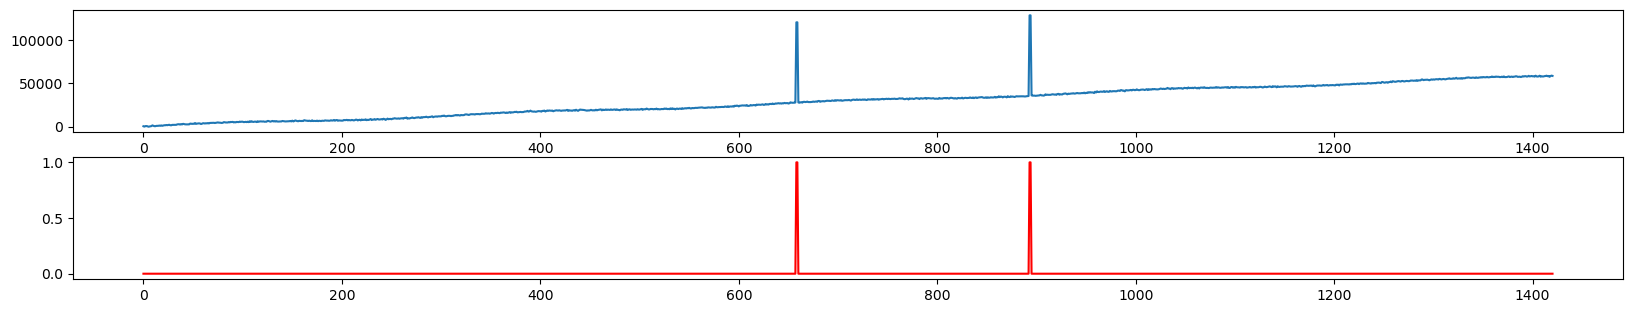

In [65]:
df = pd.read_csv("datasets/Yahoo/A2Benchmark/synthetic_91.csv")
fig, [ax0, ax1] = plt.subplots(ncols=1, nrows=2, figsize=(20, 3.5))
ax0.plot(df.value)
ax1.plot(df.is_anomaly.to_numpy(),color="red")


# one big graph(it still needs the upper definitions)

In [97]:
def Yahoo_pipeline():
    def create_mask(train, val, test, max_size):
    
        if train + val + test!= 1: 
            print("train, val and test do not add up to 1")
        else:
            train = int(max_size*train)
            val = int(max_size*val)
            test = max_size - (val+train)

            train_true = np.array([True]*train)
            train_false = np.array([False]*train)
            val_true = np.array([True]*val)
            val_false = np.array([False]*val)
            test_true = np.array([True]*test)
            test_false = np.array([False]*test)

            test_mask = np.append(np.append(train_true, val_false),test_false)
            val_mask = np.append(np.append(train_false, val_true),test_false)
            train_mask = np.append(np.append(train_false, val_false),test_true)
            return train_mask, val_mask, test_mask
    
    import os, sys
    versions = os.listdir('datasets/Yahoo/'+version)
    versions = list(filter(lambda x: ".ipynb_checkpoints" not in x, versions))
    len_ver = len(versions)
    large_X = []
    large_mask = []
    for loc_ver in versions:
        df = pd.read_csv("datasets/Yahoo/"+version+"/" + loc_ver) 
        df.loc[0, 'is_anomaly'] = 1
        large_X.append(df.value)
        large_mask.append(df.is_anomaly)
    large_X = np.array(large_X).reshape(-1)
    large_mask = np.array(large_mask).reshape(-1)
    
    if graph_type == "MTF":
        MTF = MarkovTransitionField(n_bins=int(len(large_X/100)))
        X_gaf_MTF = MTF.fit_transform(large_X.reshape(1, -1))
        edge_index, edge_weight = adjToEdgidx(X_gaf_MTF[0])
        
    elif graph_type == "vis":
        edge_index, edge_weight = adjToEdgidx(vis_matrix(large_X, vis_type))
        
    elif graph_type == "dual_VG":
        edge_index, edge_weight = adjToEdgidx_dual_VG(large_X)
    
    output = []
    x =  torch.unsqueeze(torch.tensor(large_X, dtype=torch.double), 1).clone().detach()
    edge_index = edge_index.clone().detach().to(torch.int64)
    edge_attr = torch.unsqueeze(torch.tensor(edge_weight, dtype=torch.double),1).clone().detach()
    y = torch.unsqueeze(torch.tensor(large_mask, dtype=torch.double),1)
    train_mask, val_mask, test_mask = create_mask(0.55,0.15,0.3,len(large_X))
    train_mask = torch.tensor(train_mask, dtype=torch.bool)
    val_mask = torch.tensor(val_mask, dtype=torch.bool)
    test_mask = torch.tensor(test_mask, dtype=torch.bool)
    output.append(Data(x=x, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask, edge_index=edge_index, edge_attr=edge_attr, y=y)) 
    
    global class_weights
    all_x = []
    for obj in output:
        all_x.append(obj.y.numpy())
    all_x = np.array(all_x).reshape(-1)


    class_weights = torch.tensor(class_weight.compute_class_weight(class_weight='balanced',
                                                                    classes=np.unique(all_x),
                                                                    y=all_x))
    class_weights =torch.tensor([(class_weights[1]/class_weights[0])])
    
    return output

In [ ]:
import numpy as np

class Yahoo_Dataset:
    def __init__(self, arrays, num_classes, num_edge_features, num_features, num_node_features):
        self.arrays = arrays
        self.num_classes = num_classes
        self.num_edge_features = num_edge_features
        self.num_features = num_features
        self.num_node_features = num_node_features
        
    @property
    def data(self):
        return self.arrays
    def num_classes(self):
        return self.num_classes
    def num_edge_features(self):
        return self.num_edge_features
    def num_features(self):
        return self.num_features
    def num_node_features(self):
        return self.num_node_features
    def len(self):
        return len(self.arrays.x)
    

# Create an instance of the MyList class
Yahoo_dataset = Yahoo_Dataset(arrays=output[0], num_classes = 1,num_edge_features = 1,num_features=1, num_node_features = 1, )

# Access the first array using dot notation
print(Yahoo_dataset.len)

### Lightning

In [68]:
import os

# For downloading pre-trained models
import urllib.request
from urllib.error import HTTPError

# PyTorch Lightning
import pytorch_lightning as pl

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

# PL callbacks
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import Tensor

AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/GNNs/")

# Setting the seed
# pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [69]:
gnn_layer_by_name = {"GCN": geom_nn.GCNConv, "GAT": geom_nn.GATConv, "GraphConv": geom_nn.GraphConv}

In [70]:
cora_dataset = torch_geometric.datasets.Planetoid(root=DATASET_PATH, name="Cora")

In [71]:
class GNNModel(nn.Module):
    def __init__(
        self,
        c_in,
        c_hidden,
        c_out,
        num_layers=2,
        layer_name="GCN",
        dp_rate=0.1,
        **kwargs,
    ):
        """
        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of "hidden" graph layers
            layer_name: String of the graph layer to use
            dp_rate: Dropout rate to apply throughout the network
            kwargs: Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            layers += [
                gnn_layer(in_channels=in_channels, out_channels=out_channels, **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate),
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels, out_channels=c_out, **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """
        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        for layer in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(layer, geom_nn.MessagePassing):
                x = layer(x, edge_index)
            else:
                x = layer(x)
        return x

In [72]:
class MLPModel(nn.Module):
    def __init__(self, c_in, c_hidden, c_out, num_layers=2, dp_rate=0.1):
        """
        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of hidden layers
            dp_rate: Dropout rate to apply throughout the network
        """
        super().__init__()
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            layers += [nn.Linear(in_channels, out_channels), nn.ReLU(inplace=True), nn.Dropout(dp_rate)]
            in_channels = c_hidden
        layers += [nn.Linear(in_channels, c_out)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x, *args, **kwargs):
        """
        Args:
            x: Input features per node
        """
        return self.layers(x)

In [73]:
class NodeLevelGNN(pl.LightningModule):
    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        if model_name == "MLP":
            self.model = MLPModel(**model_kwargs)
        else:
            self.model = GNNModel(**model_kwargs)
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index = data.x, data.edge_index
        x = self.model(x, edge_index)

        # Only calculate the loss on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            assert False, "Unknown forward mode: %s" % mode

        loss = self.loss_module(x[mask], data.y[mask])
        acc = (x[mask].argmax(dim=-1) == data.y[mask]).sum().float() / mask.sum()
        return loss, acc

    def configure_optimizers(self):
        # We use SGD here, but Adam works as well
        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log("test_acc", acc)

In [74]:
def train_node_classifier(model_name, dataset, **model_kwargs):
    pl.seed_everything(42)
    node_data_loader = geom_data.DataLoader(dataset, batch_size=1)

    # Create a PyTorch Lightning trainer
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
        gpus=AVAIL_GPUS,
        max_epochs=200,
        # progress_bar_refresh_rate=0,
    )  # 0 because epoch size is 1
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "NodeLevel%s.ckpt" % model_name)
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = NodeLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything()
        model = NodeLevelGNN(
            model_name=model_name, c_in=1, c_out=1, **model_kwargs
        )
        trainer.fit(model, node_data_loader, node_data_loader)
        model = NodeLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on the test set
    test_result = trainer.test(model, dataloaders=node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    _, train_acc = model.forward(batch, mode="train")
    _, val_acc = model.forward(batch, mode="val")
    result = {"train": train_acc, "val": val_acc, "test": test_result[0]["test_acc"]}
    return model, result

In [75]:
# Small function for printing the test scores
def print_results(result_dict):
    if "train" in result_dict:
        print("Train accuracy: %4.2f%%" % (100.0 * result_dict["train"]))
    if "val" in result_dict:
        print("Val accuracy:   %4.2f%%" % (100.0 * result_dict["val"]))
    print("Test accuracy:  %4.2f%%" % (100.0 * result_dict["test"]))

In [80]:
cora_dataset.len

<bound method InMemoryDataset.len of Cora()>

In [85]:
node_gnn_model, node_gnn_result = train_node_classifier(
    model_name="GNN", layer_name="GCN", dataset=Yahoo_dataset, c_hidden=16, num_layers=2, dp_rate=0.1
)
print_results(node_gnn_result)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v1.9.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file saved_models/GNNs/NodeLevelGNN.ckpt`
You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


Testing: 0it [00:00, ?it/s]

TypeError: object of type 'Yahoo_Dataset' has no len()

In [39]:
cora_dataset.data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

### Net

In [100]:
class Net_Large(pl.LightningModule):
    def __init__(self):
        super(Net_Large, self).__init__()
        
        self.conv1 = GATConv(1, 32, heads=4)
        self.lin1 = torch.nn.Linear(1, 4 * 32)
        self.conv2 = GATConv(4 * 32, 32, heads=4)
        self.lin2 = torch.nn.Linear(4 * 32, 4 * 32)
        self.conv3 = GATConv(4 * 32, 32, heads=8)
        self.lin3 = torch.nn.Linear(4 * 32, 8 * 32)
        self.conv4 = GATConv(8 * 32, 1, heads=6,concat=False)
        self.lin4 = torch.nn.Linear(8 * 32, 1)

    def forward(self, data):
        
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            assert False, "Unknown forward mode: %s" % mode
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        
        
        x = F.elu(self.conv1(x, edge_index, edge_weight) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index, edge_weight) + self.lin2(x))
        x = F.elu(self.conv3(x, edge_index, edge_weight) + self.lin3(x))
        x = self.conv4(x, edge_index, edge_weight) + self.lin4(x)
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
        return optimizer
    
    def training_step(self, data, batch_idx): 
        global mode
        mode = "train"
        out = model(data)
        loss_function = BCEWithLogitsLoss(weight=class_weights).to(device)
        train_loss = loss_function(out[data.train_mask], data.y[data.train_mask])
                       
        correct=out[data.train_mask].argmax(dim=1).eq(data.y[data.train_mask]).sum().item()
        logs={"train_loss": train_loss}
        total=len(data.y[data.train_mask])
        batch_dictionary={"loss": train_loss, "log": logs, "correct": correct, "total": total}
        return train_loss
    
    def validation_step(self, data, batch_idx):
        global mode
        mode = "val"
        out = model(data)
        loss_function = BCEWithLogitsLoss(weight=class_weights).to(device) #weight=class_weight
        val_loss = loss_function(out[data.val_mask], data.y[data.val_mask])
        
        ys, preds = [], []
        val_label = data.y[data.val_mask].cpu()
        ys.append(data.y[data.val_mask])
        preds.append((out[data.val_mask] > 0).float().cpu())     
        y, pred = torch.cat(ys, dim=0), torch.cat(preds, dim=0)
        accuracy = (pred == val_label).sum() / pred.shape[0]
    
        self.log("val_loss", val_loss)
        self.log("val_acc", accuracy)
    
    def test_step(self, data, batch_idx):
        global mode
        mode = "test"
        # this is the test loop
        out = model(data)
        loss_function = BCEWithLogitsLoss(weight=class_weights).to(device) #weight=class_weight
        test_loss = loss_function(out[data.test_mask], data.y[data.test_mask])
        
        ys, preds = [], []
        test_label = data.y[data.test_mask].cpu()
        ys.append(data.y[data.test_mask])
        preds.append((out[data.test_mask] > 0).float().cpu())
        
        y, pred = torch.cat(ys, dim=0), torch.cat(preds, dim=0)
        accuracy = (pred == test_label).sum() / pred.shape[0]
        
        self.log("test_acc", accuracy)
        return pred, y
        
    def test_epoch_end(self, outputs):
        #this function gives us in the outputs all acumulated pred and test_labels we returned in test_step
        #we transform the pred and test_label into a shape that the classification report can read
        global true_array, pred_array
        true_array=[outputs[i][1].cpu().numpy() for i in range(len(outputs))]
        pred_array = [outputs[i][0].cpu().numpy() for i in range(len(outputs))]
        pred_array = np.array(pred_array).reshape(-1, 1)
        true_array = np.array(true_array).reshape(-1, 1)
        print(confusion_matrix(true_array, pred_array))
        print(classification_report(true_array, pred_array))
        print("pred_array ",pred_array)

        
def main_2():
    if check_for_missclick() != True:
        print("one of the main parameters does not match")
    else:
        global model, loader, device
        
        early_stop = EarlyStopping(monitor='val_loss',patience=patience, strict=False,verbose=False, mode='min')
        val_checkpoint_best_acc = ModelCheckpoint(filename="best_acc", monitor = "val_acc", mode="max")
        val_checkpoint_best_loss = ModelCheckpoint(filename="best_loss", monitor = "val_loss", mode="min")
        logger = DVCLiveLogger()
        
        torch.manual_seed(SEED)
        print(SEED)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # data = output[0].to(device)
        output = generate_Yahoo()
        loader = DataLoader(output, batch_size=1, shuffle=True)

        # mode
        model = Net_Large().double()#.to(device) #net is for node classification
            
        #training
        
        trainer = pl.Trainer(logger=logger, max_epochs = range_epoch, callbacks=[val_checkpoint_best_acc,val_checkpoint_best_loss,early_stop],accelerator='gpu',devices=1)
        trainer.fit(model,loader,loader)

In [98]:
"""
this definition keeps the last output so we dont have to generate another if all parameters are the same as before, usefull for when you change the modell a lot but not the graph itself
"""
global temp_repeat_Y
#we have 9 parameters to remember
temp_repeat_Y=['']*10
def generate_Yahoo():
    if temp_repeat_Y[0] != graph_type or temp_repeat_Y[1] != classif or temp_repeat_Y[2] != len_type or temp_repeat_Y[3] != path_main or temp_repeat_Y[4] != path_properties or temp_repeat_Y[5] != path_mask or temp_repeat_Y[6] != vis_type or temp_repeat_Y[7] != vis_distance or temp_repeat_Y[8] != vis_edge_type or temp_repeat_Y[9] != version:
    
        global output
        output = Yahoo_pipeline()
        
    #remembering the last known parameter
    temp_repeat_Y[0] = graph_type 
    temp_repeat_Y[1] = classif
    temp_repeat_Y[2] = len_type
    temp_repeat_Y[3] = path_main
    temp_repeat_Y[4] = path_properties
    temp_repeat_Y[5] = path_mask
    temp_repeat_Y[6] = vis_type
    temp_repeat_Y[7] = vis_distance
    temp_repeat_Y[8] = vis_edge_type
    temp_repeat_Y[9] = version
    
    
    print(temp_repeat_Y[1] + " classification on " + temp_repeat_Y[2] + " time series using " + temp_repeat_Y[0] + " graphs" )
    return output
#if we write a parameter that is not known to the function this def will stop it faster beffore you get an error half through the graph generation 
def check_for_missclick():
    return graph_type in ("vis", "MTF", "MTF_on_vis", "vis_on_MTF","double_VG","dual_VG") and classif in ("graph", "node") and len_type in ("un/cut", "random") and vis_type in ("natural", "horizontal") and vis_distance in ('slope', 'abs_slope','distance','h_distance','v_distance','abs_v_distance') and vis_edge_type in ("undirected", "directed") and version in ('A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark')

In [99]:
graph_type = "MTF" #"vis", "MTF", "MTF_on_vis", "vis_on_MTF", "dual_VG", graph topology
classif = "node" #"graph", "node", set the type of classification
len_type = "un/cut" #"un/cut", "random", the shape of data used in later paths 
cut_len = '0' # 0 if we arent doing cut by other lengths than 300 or random 
vis_type = "natural" #"natural", "horizontal"
vis_distance = 'distance'#'slope', 'abs_slope','distance','h_distance','v_distance','abs_v_distance',
vis_edge_type = "directed" #"undirected", "directed"
version = 'A2Benchmark'
window_size=200
stride_on=False

path_main = "datasets/dataset_uncut.csv" #"dataset_uncut.csv", "dataset_cut.csv", "dataset_rss.npz", paths used for cut/uncut/random dataset
path_properties = "datasets/dataset_properties.npz"  # path to properties used for random 
path_mask = "datasets/dataset_mask.npz" # path to mask dataset used for random

SEED = 31
learning_rate = 0.0005
batch_size = 64
range_epoch = 1000 #set length of epoch
save_file="test"
name_of_save = "Yahoo7"
patience = 200
#--------------------
main_2()
original_model = model

31


/opt/conda/lib/python3.10/site-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [ 14469  16832  21456  31663  54499  54968  55365  55562  58784  61112
  64456  65770  71292  77109  79137  79636  80082  80716  81927  83035
  83120  83312  83456  84435  84483  85987  87320  89820  92657  97215
  97673  98223  98678  99663  99836 102322 102806 102855 103047 104288
 104752 104831 111256 111707 113028 113038 114045 116377 117508 117585
 118727 119996 120410 121143 121247 123041 123512 123709 125167 126954
 128365 129621 130125 130854 130881 131127 131409 131430 132041 132364
 132410 133296 134668 134804 136670 138246 138770 139155 140016 140090
 140109 140327 140458 140617 140701 140795 140870 140962 141203 141217
 141710 141847 141958 142075 142078 142083 142087 142090 142093]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
GPU a

node classification on un/cut time series using MTF graphs


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [106]:
# model = original_model
model = Net_Large.load_from_checkpoint("DvcLiveLogger/dvclive_run/checkpoints/best_loss-v2.ckpt").double()
trainer = pl.Trainer(accelerator='gpu',devices=1)
trainer.test(model, loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_datalo

Testing: 0it [00:00, ?it/s]

[[77851     9]
 [   43   252]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     77860
         1.0       0.97      0.85      0.91       295

    accuracy                           1.00     78155
   macro avg       0.98      0.93      0.95     78155
weighted avg       1.00      1.00      1.00     78155

pred_array  [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9993346333503723
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9993346333503723}]

up presents a false negative, down presents a false positive


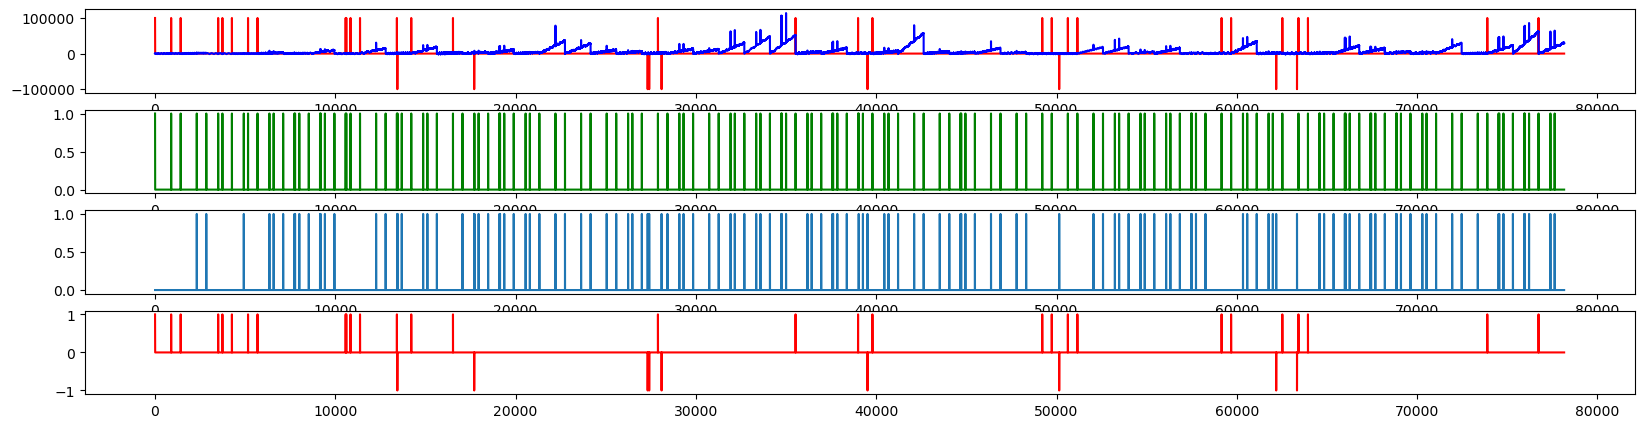

In [107]:

fig, [ax0, ax1, ax2, ax3] = plt.subplots(ncols=1, nrows=4, figsize=(20, 5))
ax0.plot((true_array-pred_array)*100000, c = "red")
ax0.plot(output[0].x[output[0].test_mask], c = "blue")
ax1.plot(true_array, c = "green")
ax2.plot(pred_array)
ax3.plot(true_array-pred_array, c= "red" )

print("up presents a false negative, down presents a false positive")

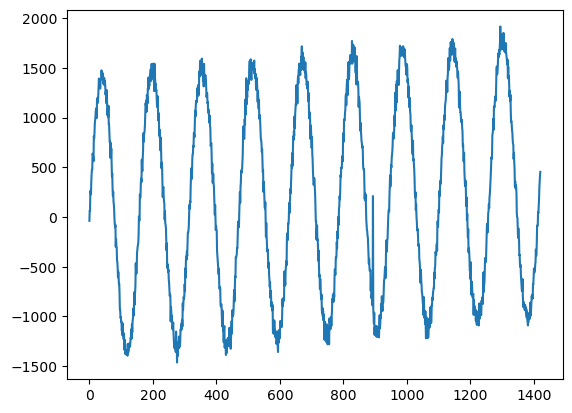

In [109]:
plt.plot(output[0].x[:int(len(output[0].x)/100)])